ADF Test Results (Before Differencing):
Passengers ADF p-value: 0.991511509628866
Lag1 ADF p-value: 0.9925254163586111

ADF Test Results (After Differencing):
Passengers ADF p-value: 0.053655499158908174
Lag1 ADF p-value: 0.05913488643940043


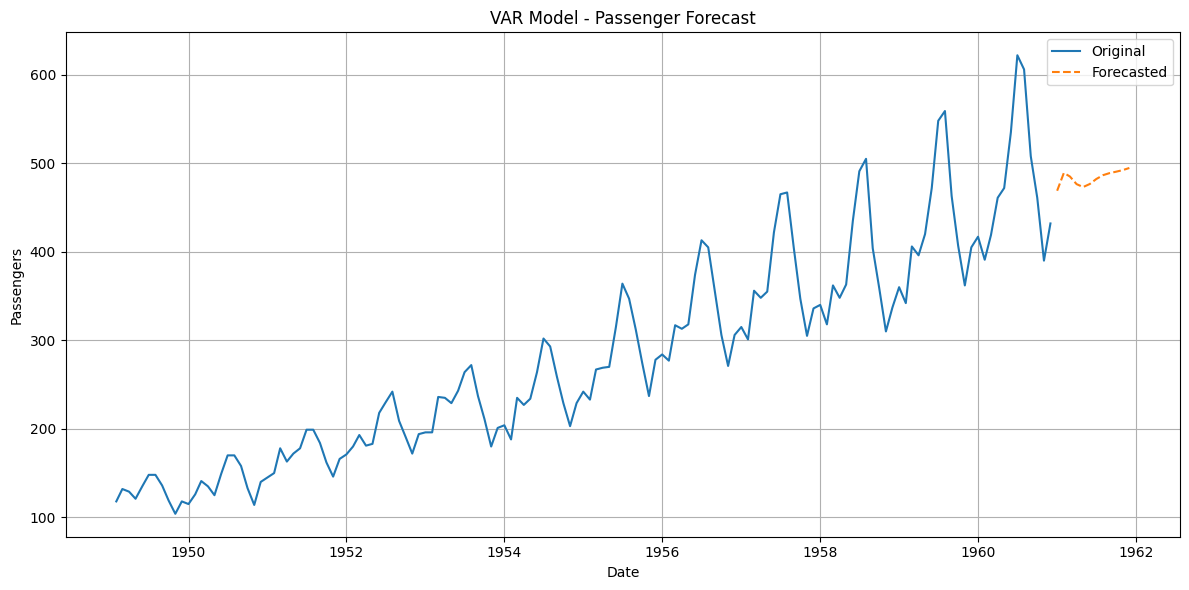

In [ ]:
# Install required packages
!pip install pandas matplotlib statsmodels --quiet

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv('/content/airline-passengers.csv')

# Parse datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.columns = ['Passengers']

# Create one lag feature to make it multivariate
df['Lag1'] = df['Passengers'].shift(1)
df.dropna(inplace=True)

# ADF Test
def adf_test(series, name=''):
    result = adfuller(series, autolag='AIC')
    print(f"{name} ADF p-value: {result[1]}")
    return result[1]

print("ADF Test Results (Before Differencing):")
for col in df.columns:
    adf_test(df[col], col)

# First-order differencing for stationarity
df_diff = df.diff().dropna()

# ADF Test After Differencing
print("\nADF Test Results (After Differencing):")
for col in df_diff.columns:
    adf_test(df_diff[col], col)

# Train VAR model
model = VAR(df_diff)

# Use a conservative lag value to avoid overfitting
results = model.fit(maxlags=5, ic='aic')

# Forecast next 12 months
lag_order = results.k_ar
forecast_input = df_diff.values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=12)

# Convert forecast to DataFrame
forecast_df = pd.DataFrame(forecast,
                           index=pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS'),
                           columns=df_diff.columns)

# Reconstruct original scale
last_row = df.iloc[-1]
forecast_actual = forecast_df.cumsum() + last_row

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'], label='Original')
plt.plot(forecast_actual['Passengers'], label='Forecasted', linestyle='--')
plt.title('VAR Model - Passenger Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
